In [1]:
import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [2]:
# Fichier avec les variables d'intéret :

df_cct = pd.read_parquet("/home/onyxia/work/cct_var_new.parquet")

In [3]:
df_cct.head()


,User,Card,date,timestamp,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,...,wk_med_amt,wk_i_med_amt,nbt_wk_i/amt_wk_i,amt/day_income,merchant_user_state_is_diff,rolling_nb_frauds_wk,rolling_nbt_wk,rolling_amt_wk,rolling_amt_med_wk,rolling_nbt_wk/amt_wk
0,0,0,2002-09-01,2002-09-01 06:21:00,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,...,1380.96,90.015,0.177748,0.819868,0,0.0,1.0,134.09,134.090,0.007458
1,0,0,2002-09-01,2002-09-01 06:42:00,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,1380.96,90.015,0.177748,0.235279,0,0.0,2.0,172.57,86.285,0.011589
2,0,0,2002-09-02,2002-09-02 06:22:00,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,...,1380.96,90.015,0.177748,0.735796,0,0.0,3.0,292.91,120.340,0.010242
3,0,0,2002-09-02,2002-09-02 17:45:00,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,...,1380.96,90.015,0.177748,0.788441,0,0.0,4.0,421.86,124.645,0.009482
4,0,0,2002-09-03,2002-09-03 06:23:00,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,...,1380.96,90.015,0.177748,0.640230,0,0.0,5.0,526.57,120.340,0.009495


In [4]:
#df_cct.columns

# Retirer les variables inutiles : ?????????????????????????????????????????????
# merchant_user_state_is_diff inutile : toujours identique 
df_cct =  df_cct.drop(["merchant_user_state_is_diff"], axis = 1)

In [5]:
df_cct =  df_cct.drop(["date"], axis = 1) # toute l'information est dans timestamp

In [6]:
df_cct =  df_cct.drop(["Zip"], axis = 1) # inutile : information avec Merchant City (suffisamment précis)

In [7]:
# Drop "User" et "Merchant Name" : Discriment trop les transactions en fonctions des Users : on veut 
# une analyse sur les transactions.

df_cct =  df_cct.drop(["User", "Merchant Name"], axis = 1)


In [8]:
# Gérer les variables catégorielles pour DBSCAN. 
# Eviter le problème de hiérarchie entre les modalités : 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?fbclid=IwAR2eCoPI9skUHDegZeP31K--Psh2thHY_5anQPtngWD6qU3caG1UxFdwtR4

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Ex : On commence par les colonnes "Use Chip" et "Errors"     (A faire  "Merchant State", "Merchant City")

enc = OneHotEncoder(handle_unknown='ignore')


features_array = enc.fit_transform(df_cct[["Use Chip", "Errors?"]]).toarray()

In [10]:
features_labels = np.hstack(np.array(enc.categories_))

In [11]:
df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [12]:
df_cct.head()

,Card,timestamp,Amount,Use Chip,Merchant City,Merchant State,MCC,Errors?,Is Fraud?,delta_t_s,...,Bad PIN,"Bad PIN,Insufficient Balance","Bad PIN,Technical Glitch",Bad Zipcode,"Bad Zipcode,Insufficient Balance","Bad Zipcode,Technical Glitch",Insufficient Balance,"Insufficient Balance,Technical Glitch",Technical Glitch,None
0,0,2002-09-01 06:21:00,134.09,Swipe Transaction,La Verne,CA,5300,None,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,2002-09-01 06:42:00,38.48,Swipe Transaction,Monterey Park,CA,5411,None,0,1260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,2002-09-02 06:22:00,120.34,Swipe Transaction,Monterey Park,CA,5411,None,0,85200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,2002-09-02 17:45:00,128.95,Swipe Transaction,Monterey Park,CA,5651,None,0,40980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,2002-09-03 06:23:00,104.71,Swipe Transaction,La Verne,CA,5912,None,0,45480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# Pour :"Merchant State", "Merchant City": 

#enc = OneHotEncoder(handle_unknown='ignore')

#features_array = enc.fit_transform(df_cct[["Merchant State", "Merchant City"]]).toarray()


In [14]:
#features_labels = np.hstack(np.array(enc.categories_))

In [15]:
#df_cct_add = pd.concat([df_cct_add, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [16]:
# Gérer les dates : "date", "timestamp" : garder que timesstamp le plus précis : supprimer les tirets : 
# df_cct["date"] = df_cct["date"].str.replace("-","")


df_cct["timestamp"] = df_cct["timestamp"].values.astype("float64")
# Gerer le type : datetime64[ns]
df_cct.head()

,Card,timestamp,Amount,Use Chip,Merchant City,Merchant State,MCC,Errors?,Is Fraud?,delta_t_s,...,Bad PIN,"Bad PIN,Insufficient Balance","Bad PIN,Technical Glitch",Bad Zipcode,"Bad Zipcode,Insufficient Balance","Bad Zipcode,Technical Glitch",Insufficient Balance,"Insufficient Balance,Technical Glitch",Technical Glitch,None
0,0,1.030861e+18,134.09,Swipe Transaction,La Verne,CA,5300,None,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1.030863e+18,38.48,Swipe Transaction,Monterey Park,CA,5411,None,0,1260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1.030948e+18,120.34,Swipe Transaction,Monterey Park,CA,5411,None,0,85200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1.030989e+18,128.95,Swipe Transaction,Monterey Park,CA,5651,None,0,40980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1.031034e+18,104.71,Swipe Transaction,La Verne,CA,5912,None,0,45480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
# Temporairement : (on a pas encore gérer ces variables catégorielles)

df_cct =  df_cct.drop(["Merchant State", "Merchant City", "Errors?"], axis = 1)

In [18]:
# On a géré la variable catégorielle Use Chip
df_cct =  df_cct.drop(["Use Chip" ], axis = 1)

In [19]:
# On retire également la variable "Card" : pas d'intérêt pour le clustering
# On souhaite étudier les types de transaction de manière générale. 
df_cct =  df_cct.drop(["Card" ], axis = 1)

In [20]:
df_cct.head()

,timestamp,Amount,MCC,Is Fraud?,delta_t_s,delta_t_s_card,day_amt,day_nbt,day_med_nbt,wk_i_nbt,...,Bad PIN,"Bad PIN,Insufficient Balance","Bad PIN,Technical Glitch",Bad Zipcode,"Bad Zipcode,Insufficient Balance","Bad Zipcode,Technical Glitch",Insufficient Balance,"Insufficient Balance,Technical Glitch",Technical Glitch,None
0,1.030861e+18,134.09,5300,0,0,0,172.57,2,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.030863e+18,38.48,5411,0,1260,1260,172.57,2,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.030948e+18,120.34,5411,0,85200,85200,249.29,2,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.030989e+18,128.95,5651,0,40980,40980,249.29,2,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.031034e+18,104.71,5912,0,45480,45480,190.90,2,2.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# Centrer réduire les variables : 

for i in range(len(df_cct.columns)):
    mean = np.mean(df_cct[df_cct.columns[i]])
    ec = np.std(df_cct[df_cct.columns[i]])
    df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec


df_cct.head()

,timestamp,Amount,MCC,Is Fraud?,delta_t_s,delta_t_s_card,day_amt,day_nbt,day_med_nbt,wk_i_nbt,...,Bad PIN,"Bad PIN,Insufficient Balance","Bad PIN,Technical Glitch",Bad Zipcode,"Bad Zipcode,Insufficient Balance","Bad Zipcode,Technical Glitch",Insufficient Balance,"Insufficient Balance,Technical Glitch",Technical Glitch,None
0,-1.920203,1.102821,-0.297017,-0.034953,-0.000006,-0.092117,-0.129295,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
1,-1.920196,-0.062837,-0.170782,-0.034953,0.000321,-0.090357,-0.129295,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
2,-1.919666,0.935184,-0.170782,-0.034953,0.022107,0.026931,0.245528,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
3,-1.919411,1.040155,0.102158,-0.034953,0.010630,-0.034856,0.245528,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
4,-1.919129,0.744626,0.398979,-0.034953,0.011798,-0.028569,-0.039742,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223


In [22]:
# On supprime les colonnes avec que des NaN : nbt_wk_i/amt_wk_i et rolling_nbt_wk/amt_wk
df_cct =  df_cct.drop(["nbt_wk_i/amt_wk_i", "rolling_nbt_wk/amt_wk"], axis = 1)
df_cct.head()


,timestamp,Amount,MCC,Is Fraud?,delta_t_s,delta_t_s_card,day_amt,day_nbt,day_med_nbt,wk_i_nbt,...,Bad PIN,"Bad PIN,Insufficient Balance","Bad PIN,Technical Glitch",Bad Zipcode,"Bad Zipcode,Insufficient Balance","Bad Zipcode,Technical Glitch",Insufficient Balance,"Insufficient Balance,Technical Glitch",Technical Glitch,None
0,-1.920203,1.102821,-0.297017,-0.034953,-0.000006,-0.092117,-0.129295,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
1,-1.920196,-0.062837,-0.170782,-0.034953,0.000321,-0.090357,-0.129295,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
2,-1.919666,0.935184,-0.170782,-0.034953,0.022107,0.026931,0.245528,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
3,-1.919411,1.040155,0.102158,-0.034953,0.010630,-0.034856,0.245528,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223
4,-1.919129,0.744626,0.398979,-0.034953,0.011798,-0.028569,-0.039742,-1.008424,-50.204151,-0.784566,...,-0.049212,-0.004881,-0.002291,-0.009234,-0.00073,-0.000536,-0.100277,-0.004329,-0.044482,0.127223


In [23]:
import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import umap
from collections import Counter

In [40]:
# Implémentation de DBSCAN : 


X = df_cct.values
X.astype(np.float64)

clustering=cluster.DBSCAN(eps=2.25, min_samples=5)
clustering.fit(X)


: 

: 

In [ ]:
# Choix de eps et min_samples :

# Choix de eps

Eps=np.linspace(1,2.5,num=10)
N=[]
L=[]
for eps in Eps:
  clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  clustering.fit(X)
  labels = clustering.labels_
  L.append(labels)
  n=np.unique(labels)
  N+=[len(n)]

sns.lineplot(x=Eps,y=N)

In [ ]:
# Nbr d'outliers : 

for s in L:
    d = Counter(s)
    for i in d:
        print(i, d[i])

In [ ]:
# Choix de min_samples : 

Eps = [2.0,2.1,2.2,2.3,2.4]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

In [ ]:
# Choix intéressant pour eps et min_samples : 


clustering=cluster.DBSCAN(eps=2.25, min_samples=5)
clustering.fit(X)
np.unique(clustering.labels_)


# Nombre de groupes : 

In [ ]:
labels = clustering.labels_
d = Counter(labels)
d[-1]

# Nombre d'outliers : 

In [35]:
# ACP : réduction de dimension => représenter la méthode DBSCAN (nuage de points)


pca = PCA()
pca.fit(df_cct)
df_cct.columns = df_cct.columns.astype("str")
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
#df_cct_pca_df["labels"] = clustering.labels_



In [36]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[5.63625125e+00 2.43849661e+00 2.13646893e+00 1.98741730e+00
 1.45481645e+00 1.32685114e+00 1.05950709e+00 1.01547363e+00
 1.00365512e+00 1.00209129e+00 1.00064995e+00 1.00041957e+00
 1.00022066e+00 1.00005185e+00 1.00002593e+00 1.00001232e+00
 1.00000713e+00 1.00000421e+00 1.00000332e+00 1.00000274e+00
 1.00000231e+00 1.00000189e+00 1.00000141e+00 1.00000105e+00
 1.00000046e+00 1.00000037e+00 1.00000019e+00 9.99993990e-01
 9.99944988e-01 9.99590687e-01 9.94485432e-01 9.83344479e-01
 9.73796628e-01 7.94921950e-01 6.56590126e-01 6.03849528e-01
 5.19220627e-01 4.61545844e-01 2.70418556e-01 2.42144089e-01
 2.08452069e-01 1.35564333e-01 5.51097268e-02 3.85946688e-02
 7.80546590e-30 5.65250293e-30]
[1.22527196e-01 5.30107937e-02 4.64449748e-02 4.32047221e-02
 3.16264433e-02 2.88445888e-02 2.30327620e-02 2.20755128e-02
 2.18185886e-02 2.17845923e-02 2.17532588e-02 2.17482506e-02
 2.17439265e-02 2.17402567e-02 2.17396933e-02 2.17393974e-02
 2.17392844e-02 2.17392212e-02 2.17392018e-02 2.17391

In [37]:
# Faire apparaître les valeurs propres sur l'ACP.  => Interpréter / comprendre les axes + représentatifs ? 


eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,5.636251e+00,12.0,12.0
1,Dim2,2.438497e+00,5.0,18.0
2,Dim3,2.136469e+00,5.0,22.0
3,Dim4,1.987417e+00,4.0,27.0
4,Dim5,1.454816e+00,3.0,30.0
5,Dim6,1.326851e+00,3.0,33.0
6,Dim7,1.059507e+00,2.0,35.0
7,Dim8,1.015474e+00,2.0,37.0
8,Dim9,1.003655e+00,2.0,39.0
9,Dim10,1.002091e+00,2.0,41.0


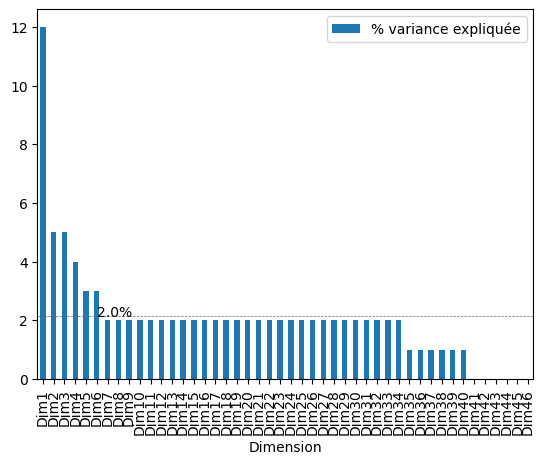

In [38]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 100/(len(pca.explained_variance_)+1), str(np.round(100/(len(pca.explained_variance_)+1)))+"%") # ajout de texte
plt.axhline(y = (100/(len(pca.explained_variance_)+1)), linewidth = .5, color = "dimgray", linestyle = "--") # (100/(len(pca.explained_variance_)+1)) (nb dimensions)
plt.show()


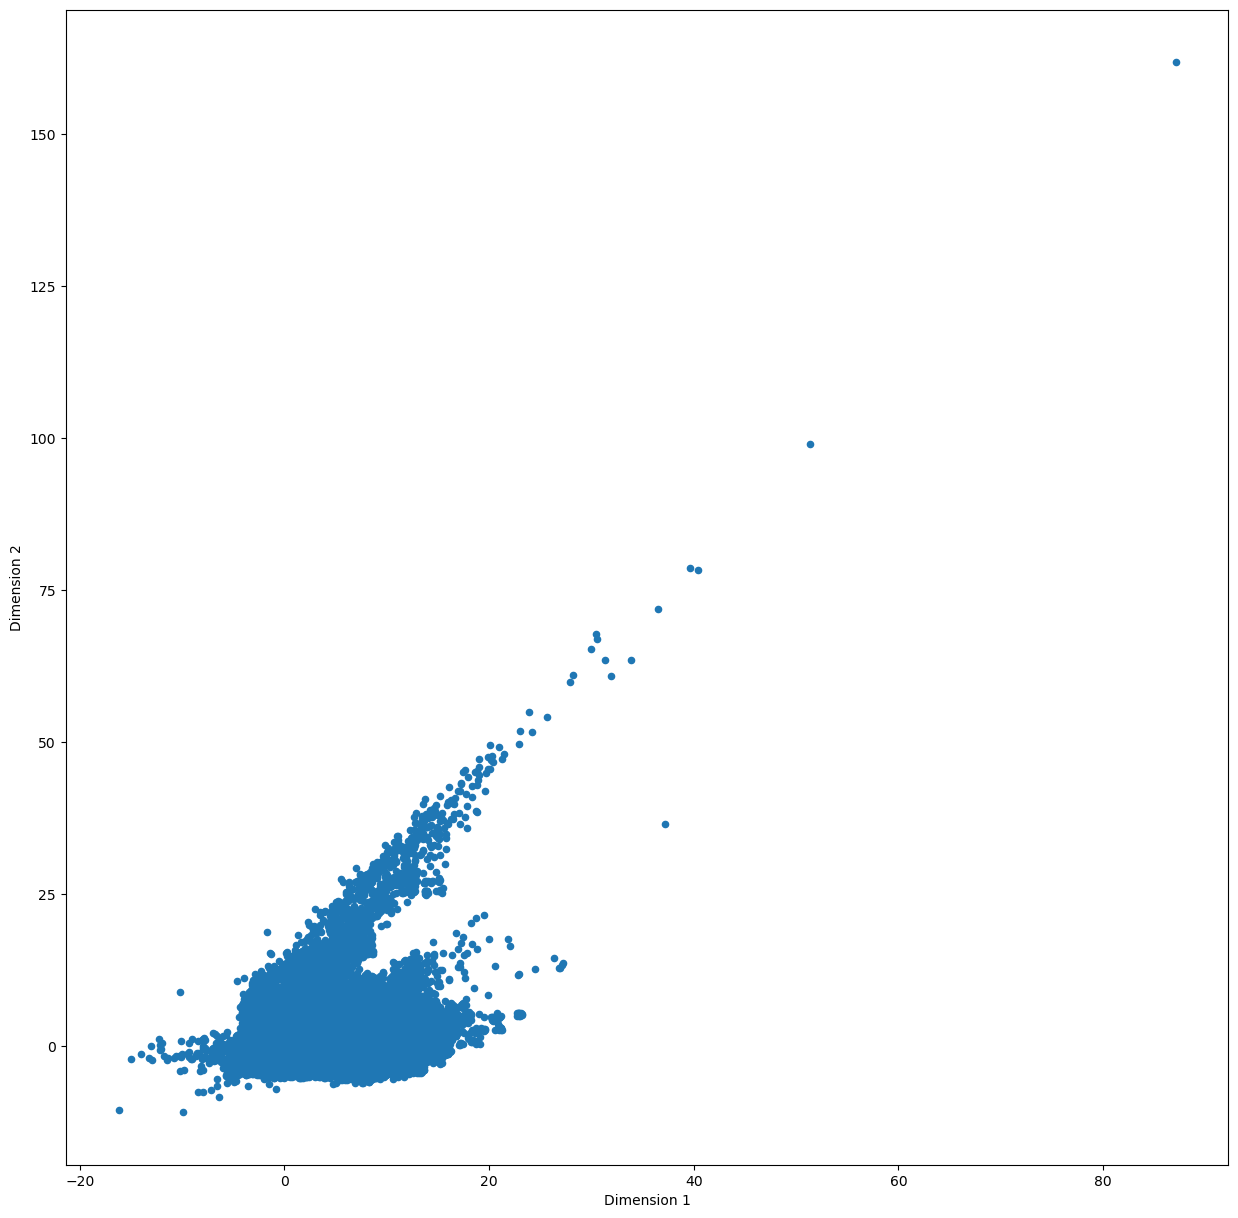

In [39]:
# Représentation de l'ACP :

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
# for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    # if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        # ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
# Représentation de DBSCAN avec l'ACP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")

In [ ]:
# ACP en cascade :........................
#- ACP en cascade : sélectionner 10 familles de variables, faire une ACP sur chaque famille, 
# récupérer les axes, faire une 2e ACP sur toutes les ACP (pour enlever le problème des variables catégorielles)
# Sparse ACP ?

In [ ]:
# UMAP : autre méthode de réduction de dimension :


reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct_add.values)

In [ ]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

In [ ]:
# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")